In [91]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

### Monte Carlo simulation of Stock Price Paths

In [3]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, M))
    return S

### Compute the Payoff

In [4]:
def payoff_fun(S, K):
    return np.maximum(K - S, 0)

### Create Shallow Neural Network

In [151]:
def create_shallow_NN(input_dim, hidden_units):
    
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    return model

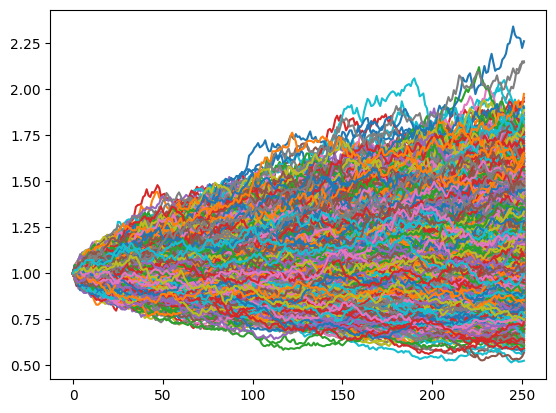

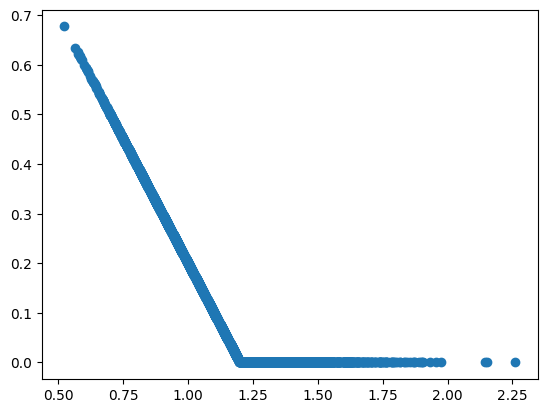

In [152]:
stock_paths = stock_price_simulator(1, 0.1, 0.2, 1, 251, 5000)
plt.plot(stock_paths.T)
plt.show()
payoffs_at_maturity = payoff_fun(stock_paths[:, -1], 1.2)
plt.scatter(stock_paths[:,-1], payoffs_at_maturity)
plt.show()

In [164]:
X = stock_paths[:, -1].reshape(-1, 1)
y = payoffs_at_maturity.reshape(-1, 1)
X.shape, y.shape

((5000, 1), (5000, 1))

In [162]:
log_prices = np.log(stock_paths)

In [165]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [166]:
model = create_shallow_NN(1, 128)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mean_squared_error', 
              metrics=['mean_absolute_error'])

In [167]:
# Set up early stopping based on validation loss with a patience of 6 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


In [168]:
# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),  # Provide validation data for monitoring
    epochs=100,                       # Set a high max epoch count; early stopping will limit training
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 0.0366 - mean_absolute_error: 0.1568 - val_loss: 0.0150 - val_mean_absolute_error: 0.1024
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.0136 - mean_absolute_error: 0.0962 - val_loss: 0.0077 - val_mean_absolute_error: 0.0704
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 0.0069 - mean_absolute_error: 0.0674 - val_loss: 0.0046 - val_mean_absolute_error: 0.0552
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 0.0045 - mean_absolute_error: 0.0534 - val_loss: 0.0042 - val_mean_absolute_error: 0.0510
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 0.0045 - mean_absolute_error: 0.0524 - val_loss: 0.0042 - val_mean_absolute_error: 0.0504
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.0044 - mean_absolute_error: 0.0520 - val_loss: 0.0042 - val_mean_absolute_error: 0.0499
Epoch 7/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.0043 - mean_absol

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


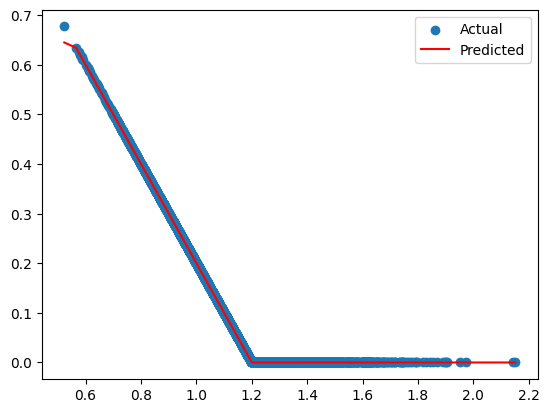

In [169]:
# Test the model
y_hat = model.predict(X_train)
plt.scatter(X_train, y_train, label='Actual')
# Sort X_train and y_hat for a smoother line plot
sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
X_train_sorted = X_train[sorted_indices]
y_hat_sorted = y_hat[sorted_indices]
plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
plt.legend()

### Continuation Value

In [170]:
def expected_value(wi, bi, Stm):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi > 0 and bi > 0:
        # Case 1: Price of a forward contract
        return wi * Stm + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        return wi * max(Stm - strike, 0)

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        # Using max(0, strike - Stm) to approximate the expectation
        return -wi * max(strike - Stm, 0)

    elif wi < 0 and bi < 0:
        # Case 4: Expected value is 0
        return 0.0


In [171]:
model.layers[0].get_weights()[1]

array([-0.10139437,  0.        , -0.01655365,  0.17219776, -0.11267285,
       -0.09893691,  0.        ,  0.101184  , -0.1198055 ,  0.        ,
       -0.07011351,  0.09507294,  0.        ,  0.        , -0.09988518,
       -0.10637011,  0.        ,  0.        , -0.12401166, -0.08904496,
       -0.06289811, -0.01037186,  0.0957175 ,  0.09509371,  0.        ,
       -0.06489236,  0.        ,  0.11868194,  0.        ,  0.        ,
        0.        , -0.10606405,  0.0967891 , -0.13052675, -0.0146506 ,
        0.        ,  0.09799929, -0.11608814, -0.11197414,  0.        ,
        0.        ,  0.0930381 ,  0.09784048,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.01199412,  0.10461596,  0.09493034,  0.        ,
       -0.07674568,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.0806562 , -0.09921021,  0.        ,  0.09780659, -0.06674857,
       -0.12543269,  0.        ,  0.        , -0.08097289, -0.10

### 0 bias and weightr was problem

In [185]:
from scipy.stats import norm

In [207]:
def analytical_expected_value(stm_1 , r, sigma, wi , bi, dt= 0.5):
    mu_y = wi * (stm_1 + (r - 0.5 * sigma**2)) * dt + bi
    sigma_y = sigma * np.sqrt(dt)
    
    first_term = sigma_y / np.sqrt(2 * np.pi) * np.exp(-mu_y**2 / (2 * sigma_y**2)) 
    second_term =  mu_y * (1 - norm.cdf(-mu_y))
    return first_term + second_term

In [216]:
no_hidden_units = 128
b2 = model.layers[1].get_weights()[1][0]

r = 0.1
sigma = 0.2

continuation_value = np.zeros(5000)
for j in range(5000):
    for i in range(no_hidden_units):
        wi = model.layers[0].get_weights()[0][0][i]
        bi = model.layers[0].get_weights()[1][i]
        w2 = model.layers[1].get_weights()[0][i][0]
        continuation_value[j] += analytical_expected_value(log_prices[j][-125], r, sigma, wi, bi) * w2
    continuation_value[j] += b2
print(continuation_value)

[ 0.05565872  0.02745494  0.11675751 ... -0.02779947  0.15489002
  0.0531649 ]


In [217]:
log_prices.shape

(5000, 252)

In [218]:
payoff_at2 = payoff_fun(np.exp(log_prices[:, -125]), 1.2)

In [219]:
Vt_m_1 = np.maximum(payoff_at2, continuation_value)

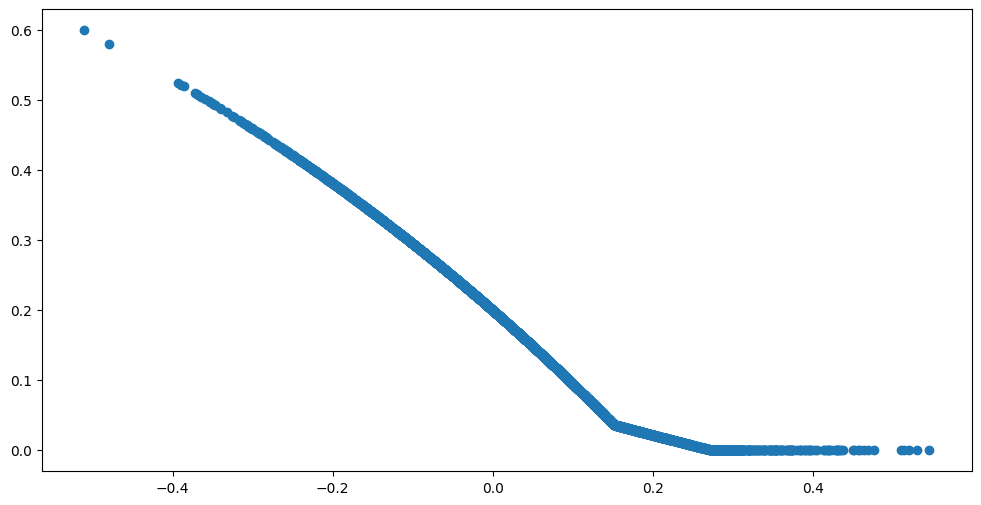

In [220]:
plt.figure(figsize=(12, 6))
plt.scatter(log_prices[:, -125], Vt_m_1, label='Payoff at t=2')

In [221]:
weights_tm = model.get_weights()  # Save the weights after training on t_m

# Step 2: Initialize a new model for date t_{m-1} and load weights from t_m
model_tm1 = create_shallow_NN(input_dim=1, hidden_units=128)
model_tm1.set_weights(weights_tm) 

In [222]:
X_tm1 = log_prices[:, -125].reshape(-1, 1)
y_tm1 = Vt_m_1.reshape(-1, 1)

In [223]:
X_tm1_train, X_tm1_val, y_tm1_train, y_tm1_val = train_test_split(X_tm1, y_tm1, test_size=0.3, random_state=42)

In [228]:
# Step 3: Compile and train model for date t_{m-1} starting from transferred weights
model_tm1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')  # Compile the model
model_tm1.fit(X_tm1_train, y_tm1_train, validation_data= (X_tm1_val, y_tm1_val), 
              epochs=100, 
              batch_size=16,
              callbacks=[early_stopping],
              verbose=1)

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 1.5147e-05 - val_loss: 5.0727e-06
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 8.4660e-06 - val_loss: 2.3101e-06
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step - loss: 4.9938e-06 - val_loss: 1.6846e-06
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step - loss: 4.2369e-06 - val_loss: 1.0750e-06
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 2.0212e-06 - val_loss: 8.1860e-07
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step - loss: 1.2778e-06 - val_loss: 4.2450e-07


In [229]:
y_tm1_hat = model_tm1.predict(X_tm1_train)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


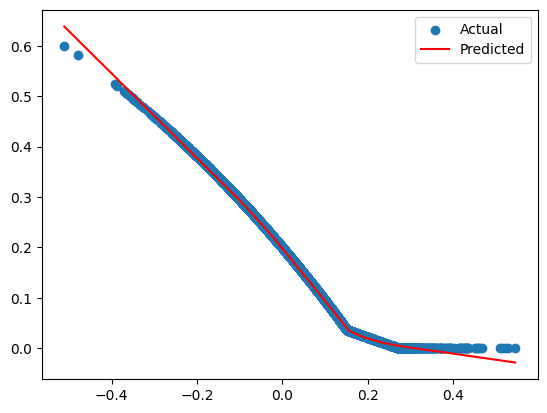

In [230]:
plt.scatter(X_tm1_train, y_tm1_train, label='Actual')
# Sort X_train and y_hat for a smoother line plot
sorted_indices = np.argsort(X_tm1_train[:, 0])  # Sort based on the first (and only) feature
X_tm1_train_sorted = X_tm1_train[sorted_indices]
y_tm1_hat_sorted = y_tm1_hat[sorted_indices]
plt.plot(X_tm1_train_sorted, y_tm1_hat_sorted, label='Predicted', color='r')
plt.legend()
